# ML Group Project - Movie Recommendation Systems PART 3
### By Jayesh Zambre, Soumya Mohan, Natalie Greener, Ryan Schmitzer, Agustin Arcos

## Import Packages and Files

In [2]:
import numpy as np
import pandas as pd
#import dask.dataframe as dd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
#reading tag and ratings data
genomescores = pd.read_csv("genome-scores.csv", header = 0)
genometags = pd.read_csv("genome-tags.csv", header = 0)

In [4]:
#reading movie, tags, links and and ratings
links = pd.read_csv("links.csv", header = 0)
movies = pd.read_csv("movies.csv", header = 0)
ratings = pd.read_csv("ratings.csv", header = 0)
tags = pd.read_csv("tags.csv", header = 0)

In [5]:
#reading imdb dataset
namebasics = pd.read_csv("name-basics.csv", header = 0)
titlebasics = pd.read_csv("title-basics.csv", header = 0)
titlecrew = pd.read_csv("title-crew.csv", header = 0)
titleratings = pd.read_csv("title-ratings.csv", header = 0)

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_1733/2852428451.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titlebasics = pd.read_csv("title-basics.csv", header = 0)


In [6]:
tags.movieId.nunique()

45251

In [7]:
#convert to lower case
tags['tag'] = tags['tag'].str.lower()
# Group the dataset by movieId and tag, then count occurrences
tag_counts = tags.groupby(["movieId", "tag"], sort=False)["tag"].count().reset_index(name="tag_count")

# Get the top 5 tags for each movieId
top_tags_per_movie = (
    tag_counts
    .sort_values(by=["movieId", "tag_count"], ascending=[True, False])
    .groupby('movieId', sort=False)
    .head(5)
)

# Concatenate the top 5 tags into a single string separated by commas
top_tags_per_movie['top_tags'] = top_tags_per_movie.groupby('movieId', sort=False)['tag'].transform(lambda x: ', '.join(x))

# Drop unnecessary columns
top_tags_per_movie.drop(['tag', 'tag_count'], axis=1, inplace=True)

# Drop duplicates and reset index
top_tags_per_movie.drop_duplicates(inplace=True)
top_tags_per_movie.reset_index(drop=True, inplace=True)

# Data Cleaning 

## MovieLens Data

In [10]:
genomescores.movieId.nunique()

13816

In [11]:
# merge genomescores & genometags on 'tagID'
gst = pd.merge(genomescores, genometags, on='tagId')
gst

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,2,1,0.04125,007
2,3,1,0.04675,007
3,4,1,0.03425,007
4,5,1,0.04300,007
...,...,...,...,...
15584443,205072,1128,0.09100,zombies
15584444,205076,1128,0.02350,zombies
15584445,205383,1128,0.03925,zombies
15584446,205425,1128,0.02850,zombies


In [12]:
# getting only those genome scores with relevance of atleast 0.9
gst.shape
gst=gst[gst.relevance>0.9].sort_values(by="movieId")

In [13]:
#gst concatenate tags
gst_group = gst.groupby('movieId')['tag'].agg(lambda x: ', '.join(x)).reset_index()

In [14]:
gst=gst_group.copy()
gst

,movieId,tag
0,1,"imdb top 250, kids, story, kids and family, co..."
1,2,"special effects, adventure, fantasy, children,..."
2,3,"good sequel, sequel, sequels"
3,4,women
4,5,"midlife crisis, pregnancy, sequel, good sequel..."
...,...,...
12356,202934,assassin
12357,203513,original
12358,204692,"original, weird"
12359,204698,"visually appealing, social commentary"


In [15]:
#merging movies(left) and genome scores and tags(right)
gstm = pd.merge(left=movies,right=gst,on='movieId',how="left")
gstm

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"imdb top 250, kids, story, kids and family, co..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"special effects, adventure, fantasy, children,..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"good sequel, sequel, sequels"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,women
4,5,Father of the Bride Part II (1995),Comedy,"midlife crisis, pregnancy, sequel, good sequel..."
...,...,...,...,...
62418,209157,We (2018),Drama,NaN
62419,209159,Window of the Soul (2001),Documentary,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,NaN
62421,209169,A Girl Thing (2001),(no genres listed),NaN


In [16]:
#clean up genres syntax from the movies dataset
#gst genres - , and space in ML dataset
gstm['genres'] = gstm['genres'].apply(lambda x: ','.join(x.split('|')))
gstm

,movieId,title,genres,tag
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co..."
1,2,Jumanji (1995),"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,..."
2,3,Grumpier Old Men (1995),"Comedy,Romance","good sequel, sequel, sequels"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance",women
4,5,Father of the Bride Part II (1995),Comedy,"midlife crisis, pregnancy, sequel, good sequel..."
...,...,...,...,...
62418,209157,We (2018),Drama,NaN
62419,209159,Window of the Soul (2001),Documentary,NaN
62420,209163,Bad Poems (2018),"Comedy,Drama",NaN
62421,209169,A Girl Thing (2001),(no genres listed),NaN


In [17]:
#imdb genres also keep
gstm.tag.isna().sum()

50062

In [18]:
# cleaning up title names
# Extracts the title name and year from the 'title' column and stores them in separate columns.
# Converts the extracted year to numeric format, handling any conversion errors, and uses a nullable integer type.
# Removes the original 'title' column, keeping only the cleaned 'title_name' and 'year' columns.

gstm[['title_name', 'year']] = gstm['title'].str.extract(r'(.*) \((\d+)\)')
gstm['year'] = pd.to_numeric(gstm['year'], errors='coerce').astype('Int64') 
gstm = gstm.drop('title', axis=1)
gstm

,movieId,genres,tag,title_name,year
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995
...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018
62419,209159,Documentary,NaN,Window of the Soul,2001
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018
62421,209169,(no genres listed),NaN,A Girl Thing,2001


In [19]:
ratings_df = ratings.groupby(['movieId'])['rating'].mean().reset_index()
ratings_df

,movieId,rating
0,1,3.893708
1,2,3.251527
2,3,3.142028
3,4,2.853547
4,5,3.058434
...,...,...
59042,209157,1.500000
59043,209159,3.000000
59044,209163,4.500000
59045,209169,3.000000


In [20]:
# merge gstm & ratings_df on 'movieId' using a left merge
gstmr = pd.merge(gstm, ratings_df, on='movieId', how="left")
gstmr
# Rename the 'rating' column to 'rating_movie'
gstmr.rename(columns={'rating': 'rating_movie'}, inplace=True)
gstmr.rename(columns={'genres': 'genre_movie'}, inplace=True)
gstmr

,movieId,genre_movie,tag,title_name,year,rating_movie
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434
...,...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018,1.500000
62419,209159,Documentary,NaN,Window of the Soul,2001,3.000000
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000
62421,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000


In [21]:
gstmr.rating_movie.isna().sum()

3376

In [22]:
# import 'links.csv' and drop the 'tmdbId' column
links = pd.read_csv("links.csv", header = 0)
links = links.drop('tmdbId', axis=1)

In [23]:
# merge gstmr & links on 'movieID'
gstmrl = pd.merge(gstmr, links, on='movieId')
gstmrl

,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId
0,1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709
1,2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497
2,3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228
3,4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885
4,5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041
...,...,...,...,...,...,...,...
62418,209157,Drama,NaN,We,2018,1.500000,6671244
62419,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986
62420,209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366
62421,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603


In [25]:
# Filters the DataFrame to keep only entries with the titleType 'movie'.
# Removes the prefix 'tt' from the 'tconst' column values, typically representing unique identifiers for titles.
# Strips leading zeros from the 'tconst' column values if present.
# Returns the modified DataFrame 'titlebasics'.

titlebasics = titlebasics[titlebasics['titleType'] == 'movie']
titlebasics['tconst'] = titlebasics['tconst'].str.replace('tt', '')
titlebasics['tconst'] = titlebasics['tconst'].apply(lambda x: x.lstrip('0'))
titlebasics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,9,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
...,...,...,...,...,...,...,...,...,...
10588573,9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
10588600,9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
10588612,9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
10588622,9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama


In [26]:
# Converts the 'year' column in the 'gstmrl' DataFrame to string type.
# Converts the 'startYear' column in the 'titlebasics' DataFrame to string type.
# Converts the 'imdbId' column in the 'gstmrl' DataFrame to string type.
# Merges the 'titlebasics' and 'gstmrl' DataFrames based on the 'tconst' and 'imdbId' columns, retaining all rows from 'gstmrl'.
# Renames the 'genres' column in the merged DataFrame to 'genre_imdb'.
# Returns the merged DataFrame 'bruh'.

gstmrl['year'] = gstmrl['year'].astype(str)
titlebasics['startYear'] = titlebasics['startYear'].astype(str)
gstmrl['imdbId'] = gstmrl['imdbId'].astype(str)
bruh = pd.merge(titlebasics, gstmrl, left_on='tconst', right_on='imdbId', how='right')
bruh.rename(columns={'genres': 'genre_imdb'}, inplace=True)
bruh

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genre_imdb,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId
0,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709
1,113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family",2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497
2,113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance",3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228
3,114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance",4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885
4,113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance",5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,6671244,movie,Wij,Wij,0,2018,\N,100,Drama,209157,Drama,NaN,We,2018,1.500000,6671244
62419,297986,movie,Window of the Soul,Janela da Alma,0,2001,\N,73,Documentary,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986
62420,6755366,movie,Bad Poems,Rossz versek,0,2018,\N,97,"Comedy,Drama",209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366
62421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603


## IMDB Data

In [29]:
# merge namebasics & titlecrew dataset together by a left merge on 'nconst' and right merge on 'directors'
directors = pd.merge(namebasics, titlecrew, left_on='nconst', right_on='directors')
directors

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,directors,writers
0,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038468,nm0000005,"nm0102602,nm0340471,nm0000005"
1,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038675,nm0000005,"nm0000005,nm0279027"
2,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0039834,nm0000005,"nm0000005,nm0845496"
3,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040418,nm0000005,"nm0000005,nm0529508"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040622,nm0000005,nm0249647
...,...,...,...,...,...,...,...,...,...
4887230,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18361688,nm9993694,"nm9993694,nm0592792,nm13445917"
4887231,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18687502,nm9993694,"nm11789966,nm9993694,nm13445916"
4887232,nm9993696,Ibrahim-Aloduley,\N,\N,"director,editor",tt8744160,tt8744160,nm9993696,\N
4887233,nm9993708,Eli Bevins,\N,\N,"producer,director,writer","tt14508814,tt11702702,tt11772904,tt11772858",tt9046122,nm9993708,\N


In [31]:
# merge the directors & titleratings dataset together on 'tconst'
imdb = pd.merge(directors, titleratings, on='tconst')
imdb

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,tconst,directors,writers,averageRating,numVotes
0,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038468,nm0000005,"nm0102602,nm0340471,nm0000005",6.6,1677
1,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0038675,nm0000005,"nm0000005,nm0279027",6.4,3464
2,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0039834,nm0000005,"nm0000005,nm0845496",6.4,2173
3,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040418,nm0000005,"nm0000005,nm0529508",6.6,2731
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986",tt0040622,nm0000005,nm0249647,6.4,1490
...,...,...,...,...,...,...,...,...,...,...,...
995546,nm9993123,Rajdeep Dhanuka,\N,\N,"director,writer,assistant_director","tt8866550,tt10199974,tt8866396,tt8742880",tt8742880,nm9993123,"nm9993124,nm9993123",8.9,13
995547,nm9993154,Carlos Milite,\N,\N,"director,writer,visual_effects","tt26733150,tt12275324,tt10470278,tt8742964",tt12275324,nm9993154,"nm11559516,nm9993154",5.9,17
995548,nm9993205,João Brás,\N,\N,"director,editor,writer","tt15192934,tt29425971,tt29142641,tt22614348",tt10212264,nm9993205,"nm9993205,nm10636794",6.7,14
995549,nm9993694,Chinmay Mishra,\N,\N,"actor,director,writer","tt8737752,tt18687502,tt9083282,tt18361688",tt18361688,nm9993694,"nm9993694,nm0592792,nm13445917",8.8,35


# Final Merge

In [32]:
# Removes the prefix 'tt' from the 'tconst' column values in the 'imdb' DataFrame.
# Strips leading zeros from the 'tconst' column values in the 'imdb' DataFrame.
# Merges the 'bruh' and 'imdb' DataFrames based on the 'tconst' column, keeping all rows from 'bruh'.
# Returns the merged DataFrame 'esketit'.

imdb['tconst'] = imdb['tconst'].str.replace('tt', '')
imdb['tconst'] = imdb['tconst'].apply(lambda x: x.lstrip('0'))
esketit = pd.merge(bruh, imdb, on='tconst',how="left")
esketit

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genre_imdb,movieId,genre_movie,tag,title_name,year,rating_movie,imdbId,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,directors,writers,averageRating,numVotes
0,114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy",1,"Adventure,Animation,Children,Comedy,Fantasy","imdb top 250, kids, story, kids and family, co...",Toy Story,1995,3.893708,114709,nm0005124,John Lasseter,1957,\N,"producer,writer,director","tt0120363,tt0114709,tt0317219,tt0120623",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,1060309.0
1,113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family",2,"Adventure,Children,Fantasy","special effects, adventure, fantasy, children,...",Jumanji,1995,3.251527,113497,nm0002653,Joe Johnston,1950,\N,"director,visual_effects,producer","tt0082971,tt0102803,tt0132477,tt0458339",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,373789.0
2,113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance",3,"Comedy,Romance","good sequel, sequel, sequels",Grumpier Old Men,1995,3.142028,113228,nm0222043,Howard Deutch,1950,\N,"director,producer,miscellaneous","tt17543592,tt1046163,tt0091790,tt0094006",nm0222043,nm0425756,6.6,29575.0
3,114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance",4,"Comedy,Drama,Romance",women,Waiting to Exhale,1995,2.853547,114885,nm0001845,Forest Whitaker,1961,\N,"actor,producer,director","tt0455590,tt0185183,tt1825683,tt1327773",nm0001845,"nm0573334,nm0060103",6.0,12054.0
4,113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance",5,Comedy,"midlife crisis, pregnancy, sequel, good sequel...",Father of the Bride Part II,1995,3.058434,113041,nm0796124,Charles Shyer,\N,\N,"writer,producer,assistant_director","tt0120783,tt0081375,tt0101862,tt0375173",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,41396.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,6671244,movie,Wij,Wij,0,2018,\N,100,Drama,209157,Drama,NaN,We,2018,1.500000,6671244,nm1415482,Rene Eller,\N,\N,"director,writer,producer",tt6671244,nm1415482,"nm1415482,nm1818234",5.6,3343.0
62419,297986,movie,Window of the Soul,Janela da Alma,0,2001,\N,73,Documentary,209159,Documentary,NaN,Window of the Soul,2001,3.000000,297986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62420,6755366,movie,Bad Poems,Rossz versek,0,2018,\N,97,"Comedy,Drama",209163,"Comedy,Drama",NaN,Bad Poems,2018,4.500000,6755366,nm2520391,Gábor Reisz,1980,\N,"director,writer,composer","tt3496334,tt27788968,tt6755366,tt2351598",nm2520391,nm2520391,7.5,2814.0
62421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209169,(no genres listed),NaN,A Girl Thing,2001,3.000000,249603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
esketit.shape

(62423, 26)

In [34]:
# drop columns ('endYear', 'isAdult', 'originalTitle', 'titleType', 'startYear', 'nconst', 'birthYear', 'deathYear', 'writers')
yeet = esketit.drop(['endYear', 'isAdult', 'originalTitle', 'titleType', 'startYear', 'nconst', 'birthYear', 'deathYear', 'writers'], axis=1)
yeet.shape

(62423, 17)

In [35]:
df=yeet.copy()

In [36]:
# Check for missing values (NaN) in each column of the DataFrame
df.isna().sum()

tconst                9456
primaryTitle          9456
runtimeMinutes        9456
genre_imdb            9456
movieId                  0
genre_movie              0
tag                  50062
title_name             416
year                     0
rating_movie          3376
imdbId                   0
primaryName          14046
primaryProfession    14046
knownForTitles       14046
directors            14046
averageRating        14046
numVotes             14046
dtype: int64

In [37]:
# Replace "(no genres listed)" with NaN in 'genre_movies'
df['genre_movie'] = df['genre_movie'].replace('(no genres listed)', np.nan)

In [38]:
df['genre_movie'].isna().sum()

5062

In [39]:
# Function to combine and remove duplicates
def combine_genres(row):
    # Split and combine genres from both columns, handling NaN values
    imdb_genres = row['genre_imdb'].split(', ') if isinstance(row['genre_imdb'], str) else []
    movies_genres = row['genre_movie'].split(', ') if isinstance(row['genre_movie'], str) else []
    
    all_genres = imdb_genres + movies_genres
    
    # Remove duplicates using a set and maintain order
    unique_genres = list(dict.fromkeys(all_genres))
    
    return ', '.join(unique_genres)

# Apply the function to create a new 'unique_genres' column as a string
df['unique_genres'] = df.apply(combine_genres, axis=1)

In [40]:
# Convert 'unique_genres' to a set and then back to a string
df['unique_genres'] = df['unique_genres'].apply(lambda x: ', '.join(set(x.split(','))))

In [42]:
df.shape

(62423, 18)

In [43]:
df2=df[df["unique_genres"]!=""]

In [44]:
df2.shape

(61056, 18)

In [46]:
# Drop the original genre columns if needed
df2.drop(['genre_imdb', 'genre_movie'], axis=1, inplace=True)

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_1733/155365076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['genre_imdb', 'genre_movie'], axis=1, inplace=True)


In [47]:
df2.shape

(61056, 16)

In [48]:
from collections import Counter

# Define a function to clean and return unique genres from a string
def get_unique_genres(genre_string):
    # Split by comma, strip whitespaces, remove empty strings, and ensure uniqueness
    genres = set(genre.strip() for genre in genre_string.split(',') if genre.strip())
    # Convert back to a sorted list and join into a string for consistency
    return ', '.join(sorted(genres))

# Apply the function to each entry in the 'unique_genres' column
# Ensure the 'unique_genres' column is a string type to avoid errors during split
df2['unique_genres'] = df2['unique_genres'].astype(str)
df2['cleaned_unique_genres'] = df2['unique_genres'].apply(get_unique_genres)

# Create a counter for the cleaned genres to check the occurrence of each genre
cleaned_genre_counts = Counter()
# Use a list comprehension to split and strip genres for accurate counting
[cleaned_genre_counts.update(genre.strip() for genre in genres.split(',')) for genres in df2['cleaned_unique_genres']]

# Now, we can display the most common genres to ensure there are no duplicates
print(cleaned_genre_counts.most_common(10))

# Drop the original 'unique_genres' column as it is no longer needed
df2 = df2.drop('unique_genres', axis=1)

# The dataframe df2 now contains the cleaned and unique genres in the 'cleaned_unique_genres' column
# and the 'unique_genres' column has been removed.b

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_1733/512743614.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['unique_genres'] = df2['unique_genres'].astype(str)
/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_1733/512743614.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cleaned_unique_genres'] = df2['unique_genres'].apply(get_unique_genres)


[('Drama', 32566), ('Comedy', 20177), ('Romance', 11225), ('Thriller', 10652), ('Action', 9571), ('Crime', 8900), ('Horror', 6940), ('Adventure', 6361), ('Documentary', 6115), ('Mystery', 4981)]


In [49]:
df2.isna().sum()

tconst                    8089
primaryTitle              8089
runtimeMinutes            8089
movieId                      0
tag                      48705
title_name                 346
year                         0
rating_movie              3323
imdbId                       0
primaryName              12679
primaryProfession        12679
knownForTitles           12679
directors                12679
averageRating            12679
numVotes                 12679
cleaned_unique_genres        0
dtype: int64

In [50]:
# Merge two DataFrames, df2 and top_tags_per_movie, based on the 'movieId' column
df3=pd.merge(df2,top_tags_per_movie,on="movieId",how="left")

In [51]:
df3.shape

(61056, 17)

In [52]:
df3.isna().sum()

tconst                    8089
primaryTitle              8089
runtimeMinutes            8089
movieId                      0
tag                      48705
title_name                 346
year                         0
rating_movie              3323
imdbId                       0
primaryName              12679
primaryProfession        12679
knownForTitles           12679
directors                12679
averageRating            12679
numVotes                 12679
cleaned_unique_genres        0
top_tags                 16291
dtype: int64

In [54]:
df4=df3[["title_name","rating_movie","primaryName","primaryProfession","averageRating","top_tags","cleaned_unique_genres","numVotes","year","movieId"]]

In [55]:
df4.dropna(inplace=True)

/var/folders/tj/tf2jmz9s375_4q5rcbr456340000gn/T/ipykernel_1733/1595090722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.dropna(inplace=True)


In [56]:
df4.shape

(33315, 10)

In [58]:
df4.sort_values("year",ascending=False).head(10)

,title_name,rating_movie,primaryName,primaryProfession,averageRating,top_tags,cleaned_unique_genres,numVotes,year,movieId
57952,Little,2.304348,Tina Gordon,"writer,director,producer",5.5,"being a kid again, bitch, body swap, child as ...","Comedy, Fantasy, Romance",14525.0,2019,200326
58409,The Lighthouse,3.669118,Robert Eggers,"production_designer,director,writer",7.4,"willem dafoe, great acting, black and white, l...","Drama, Fantasy, Horror",251335.0,2019,201340
58420,Long Shot,3.304147,Jonathan Levine,"producer,director,writer",6.8,"comedy, politics, jim's list, reviewed, theater","Comedy, Romance",120894.0,2019,201368
33256,Shazam!,3.397516,David F. Sandberg,"director,writer,producer",7.0,"superhero, funny, magic, dc comics, superhuman...","Action, Adventure, Comedy, Fantasy, Sci-Fi",381983.0,2019,143345
58456,Knock Down the House,3.953488,Rachel Lears,"cinematographer,producer,director",7.4,"documentary, politics, political, women, alexa...",Documentary,12945.0,2019,201444
58467,Creep Nation,3.333333,John Geddes,"producer,sound_department,director",4.4,"air bnb, murder, revenge, surveillance","Horror, Thriller",250.0,2019,201480
58490,Steel Country,2.277778,Simon Fellows,"director,writer,producer",6.2,"murder, mystery, thriller, andrew scott, child...","Mystery, Thriller",5269.0,2019,201538
58496,Men in Black: International,2.886719,F. Gary Gray,"director,producer,actor",5.6,"aliens, humorous, tessa thompson, matt hollowa...","Action, Adventure, Comedy, Sci-Fi",145728.0,2019,201586
58497,Toy Story 4,3.624444,Josh Cooley,"actor,writer,director",7.7,"pixar, sequel, touching, friendship, bittersweet","Adventure, Animation, Children, Comedy",277312.0,2019,201588
58499,Brightburn,3.062992,David Yarovesky,"director,editor,producer",6.1,"predictable, anti-hero, supernatural, jump sca...","Drama, Horror, Mystery, Sci-Fi, Thriller",106826.0,2019,201594


# Deep Neural Network 

## Prepare the data

In [59]:
# It then splits each string by the separator ', ' into a list of genres for each row. The expand=True argument transforms these lists into separate columns in the new DataFrame genres, where each column represents one of the genres extracted from the original comma-separated string.
# Next we converts the genres DataFrame into a Series with a multi-level index created by stacking the columns. This effectively creates a single column of all genres across all rows, with duplicates included. Wrapping this with set() extracts the unique genres from this collection, creating a set of all unique genres present in the original cleaned_unique_genres column.
# The for loop iterates over each genre in the unique_genres set. For each genre, it adds a new column to df5 with the same name as the genre. This column is filled with 1s and 0s, depending on whether the genre is present in the original cleaned_unique_genres list for each row or not. This is accomplished by applying a lambda function row-wise (axis=1) to the genres DataFrame. The lambda function checks if the genre is in the list of genres for that row. If the genre is present, the function returns 1; otherwise, it returns 0.


df5= df4.copy()

genres = df5['cleaned_unique_genres'].str.split(', ', expand=True)
unique_genres = set(genres.stack())
for genre in unique_genres:
    df5[genre] = genres.apply(lambda row: 1 if genre in row.values else 0, axis=1)
df5


,title_name,rating_movie,primaryName,primaryProfession,averageRating,top_tags,cleaned_unique_genres,numVotes,year,movieId,Biography,Fantasy,Action,Music,News,Animation,Sci-Fi,Comedy,IMAX,Mystery,Western,Drama,Romance,Crime,Thriller,\N,Adventure,Film-Noir,Family,Reality-TV,Musical,History,Sport,Horror,War,Documentary,Adult,Children
0,Toy Story,3.893708,John Lasseter,"producer,writer,director",8.3,"pixar, animation, disney, tom hanks, funny","Adventure, Animation, Children, Comedy, Fantasy",1060309.0,1995,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,Jumanji,3.251527,Joe Johnston,"director,visual_effects,producer",7.1,"robin williams, fantasy, time travel, board ga...","Adventure, Children, Comedy, Family, Fantasy",373789.0,1995,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2,Grumpier Old Men,3.142028,Howard Deutch,"director,producer,miscellaneous",6.6,"fishing, moldy, old, sequel, jack lemmon","Comedy, Romance",29575.0,1995,3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,2.853547,Forest Whitaker,"actor,producer,director",6.0,"chick flick, characters, based on novel or boo...","Comedy, Drama, Romance",12054.0,1995,4,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II,3.058434,Charles Shyer,"writer,producer,assistant_director",6.1,"steve martin, pregnancy, family, wedding, aging","Comedy, Family, Romance",41396.0,1995,5,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60978,Pressure Point,3.000000,David Giancola,"producer,director,writer",2.6,rifftrax,"Action, Drama, Thriller",360.0,1997,208769,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
60989,Lady and the Tramp,3.625000,Charlie Bean,"animation_department,art_department,director",6.2,might like,"Adventure, Comedy, Family, Romance",24314.0,2019,208800,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
60994,Noelle,3.000000,Marc Lawrence,"writer,miscellaneous,producer",6.3,might like,"Children, Comedy, Family, Fantasy",26934.0,2019,208813,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
61015,The Devil's Partner,2.500000,Charles R. Rondeau,"director,producer",5.2,"black and white, deal with the devil",Horror,558.0,1961,208933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [63]:
# dropping columns we do not want in our model
df5 = df5.drop(['rating_movie', 'primaryProfession', 'top_tags', 'cleaned_unique_genres', 'movieId'], axis=1)

In [64]:
df5.head(20)

,title_name,primaryName,averageRating,numVotes,year,Biography,Fantasy,Action,Music,News,Animation,Sci-Fi,Comedy,IMAX,Mystery,Western,Drama,Romance,Crime,Thriller,\N,Adventure,Film-Noir,Family,Reality-TV,Musical,History,Sport,Horror,War,Documentary,Adult,Children
0,Toy Story,John Lasseter,8.3,1060309.0,1995,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,Jumanji,Joe Johnston,7.1,373789.0,1995,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2,Grumpier Old Men,Howard Deutch,6.6,29575.0,1995,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,Forest Whitaker,6.0,12054.0,1995,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II,Charles Shyer,6.1,41396.0,1995,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,Heat,Michael Mann,8.3,712987.0,1995,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Sabrina,Sydney Pollack,6.3,44210.0,1995,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Tom and Huck,Peter Hewitt,5.5,11580.0,1995,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
8,Sudden Death,Peter Hyams,5.8,36810.0,1995,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9,GoldenEye,Martin Campbell,7.2,269087.0,1995,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [65]:
df5.dtypes

title_name        object
primaryName       object
averageRating    float64
numVotes         float64
year              object
Biography          int64
Fantasy            int64
Action             int64
Music              int64
News               int64
Animation          int64
Sci-Fi             int64
Comedy             int64
IMAX               int64
Mystery            int64
Western            int64
Drama              int64
Romance            int64
Crime              int64
Thriller           int64
\N                 int64
Adventure          int64
Film-Noir          int64
Family             int64
Reality-TV         int64
Musical            int64
History            int64
Sport              int64
Horror             int64
War                int64
Documentary        int64
Adult              int64
Children           int64
dtype: object

In [66]:
# It starts by selecting 'averageRating' from the DataFrame df5 as the target variable for a prediction task, while the remaining columns are treated as features. 
# To prepare these features for machine learning algorithms, a preprocessing pipeline is established using make_column_transformer. 
# This pipeline applies StandardScaler to the numerical columns 'numVotes' and 'year' for normalization, ensuring that these features contribute equally to model training by having a mean of 0 and a standard deviation of 1. 
# For categorical variables 'title_name' and 'primaryName', OneHotEncoder is used to convert them into a format suitable for model training, creating binary columns for each category and dealing with any unknown categories by ignoring them. 
# The preprocessed feature matrix X is obtained by applying this transformation to the features, and y holds the target variable. 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

# Let's consider 'averageRating' as the target variable and the rest as features
features = df5.drop('averageRating', axis=1)
target = df5['averageRating']

# Preprocess the dataset
preprocessor = make_column_transformer(
    (StandardScaler(), ['numVotes', 'year']),
    (OneHotEncoder(handle_unknown='ignore'), ['title_name', 'primaryName'])
)

X = preprocessor.fit_transform(features)
y = target 

In [67]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (33315, 45493)
Shape of y: (33315,)


## Define the model ("Relu" activation)

In [68]:
# This code sets up a TensorFlow-based neural network for regression
# defining a custom RMSE metric and using a Sequential model with layers of 128, 64, 32 neurons, and a single output neuron
# It compiles the model with the Adam optimizer, mean squared error loss, and evaluates performance with MAE, MSE, and RMSE metrics, preparing it for training on continuous value prediction.


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K  # Correct import for K

# Define RMSE as a custom metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

#Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) 
])
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae', 'mse', rmse])  


2024-03-18 15:44:00.971534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the model

In [69]:
# Split the dataset into 80% training and 20% testing sets, ensuring reproducibility with a random_state of 42
# Convert the sparse X_train matrix to a dense NumPy array for model compatibility
# Train the neural network model on the dense training data for 20 epochs in batches of 32, setting aside 20% of the training data for validation


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_dense = X_train.toarray()  # Convert to dense NumPy array
y_train_dense = y_train  # Reshape y_train to match the shape of X_train_dense

model.fit(X_train_dense, y_train_dense, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
667/667 [==============================] - 47s 69ms/step - loss: 3.3621 - mae: 1.1671 - mse: 3.3621 - rmse: 1.3895 - val_loss: 1.0622 - val_mae: 0.8142 - val_mse: 1.0622 - val_rmse: 1.0211
Epoch 2/20
667/667 [==============================] - 42s 63ms/step - loss: 0.5569 - mae: 0.5776 - mse: 0.5569 - rmse: 0.7352 - val_loss: 0.9139 - val_mae: 0.7269 - val_mse: 0.9139 - val_rmse: 0.9454
Epoch 3/20
667/667 [==============================] - 43s 64ms/step - loss: 0.1761 - mae: 0.3077 - mse: 0.1761 - rmse: 0.4096 - val_loss: 0.9169 - val_mae: 0.7433 - val_mse: 0.9169 - val_rmse: 0.9477
Epoch 4/20
667/667 [==============================] - 43s 64ms/step - loss: 0.1085 - mae: 0.2484 - mse: 0.1085 - rmse: 0.3234 - val_loss: 0.9269 - val_mae: 0.7525 - val_mse: 0.9269 - val_rmse: 0.9536
Epoch 5/20
667/667 [==============================] - 43s 64ms/step - loss: 0.0898 - mae: 0.2308 - mse: 0.0898 - rmse: 0.2949 - val_loss: 0.9275 - val_mae: 0.7509 - val_mse: 0.9275 - val_rmse: 0.9537


In [71]:
# model's architecture details like layer types, outputs, and the number of parameters, in the variable DNN_sum
DNN_sum = model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5823232   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5833601 (22.25 MB)
Trainable params: 5833601 (22.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluate and Use the Model

In [72]:
# Convert test data from sparse to dense
X_test_dense = X_test.toarray() 

# Evaluate the model with dense test data
score = model.evaluate(X_test_dense, y_test)
print("Evaluation score:", score)

# Make predictions with dense test data
predictions = model.predict(X_test_dense)
print("Predictions:", predictions)


209/209 [==============================] - 1s 5ms/step - loss: 0.8818 - mae: 0.7175 - mse: 0.8818 - rmse: 0.9296
Evaluation score: [0.8818031549453735, 0.7175434827804565, 0.8818031549453735, 0.9295737743377686]
209/209 [==============================] - 1s 5ms/step
Predictions: [[6.985125 ]
 [6.9383287]
 [6.729861 ]
 ...
 [6.648065 ]
 [6.950854 ]
 [6.9214396]]


## Model Evaluation ('relu'):
#### Loss: 
The loss is 0.8818. Since the loss is the same for loss and MSE, this means that, on average, the squared difference between the predicted ratings and the actual ratings is 0.9296. Considering the range of ratings (0-10), this loss is relatively low, but ideally, you would want it to be lower to ensure better prediction accuracy.

#### MAE (Mean Absolute Error): 
An MAE of 0.7175 on a 0-10 scale indicates that the model's predictions are, on average, 0.7175 points off from the true ratings. In the context of movie ratings, a difference of less than one point on average can be considered a good performance, although for some applications even smaller errors would be desired.

#### MSE (Mean Squared Error): 
With MSE also being 0.8818, this suggests the average squared deviation is less than 1 rating point. The square in MSE means that larger errors are heavily penalized, which can be useful since its important to avoid big mistakes in the movie rating predictions.

#### Model Performance:

Given that the typical audience rating scale has a granularity that goes down to 0.1 (e.g., a movie could have a rating of 7.1 or 7.2), an MAE of 0.7175 means that the model's predictions are reasonably close to the true values. However, whether this error is acceptable depends on the use case. For a recommendation system where the goal is to rank movies, an error of less than one point might be acceptable. However, for precise prediction or analytics, one might strive for a lower MAE.

### Prediction ('Relu') Model

In [85]:
Train, Test = train_test_split(df5, test_size=0.2, random_state=42)

In [86]:
Test[1:2]

,title_name,primaryName,averageRating,numVotes,year,Biography,Fantasy,Action,Music,News,Animation,Sci-Fi,Comedy,IMAX,Mystery,Western,Drama,Romance,Crime,Thriller,\N,Adventure,Film-Noir,Family,Reality-TV,Musical,History,Sport,Horror,War,Documentary,Adult,Children
29497,Spy,Paul Feig,7.0,257550.0,2015,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
# Step 1: Preprocess the new movie data
new_movie_preprocessed = preprocessor.transform(Test)

# If your model requires a dense input, convert the sparse matrix to a dense array
new_movie_preprocessed_dense = new_movie_preprocessed.toarray()

# Step 2: Predict the rating using the trained model
predicted_rating = model.predict(new_movie_preprocessed_dense)

print("Movie name: ", Test['title_name'][1:2], ", Actual Rating = :", Test['averageRating'][1:2])
print("Predicted Average Rating:", predicted_rating[1:2])

209/209 [==============================] - 1s 5ms/step
Movie name:  29497    Spy
Name: title_name, dtype: object , Actual Rating = : 29497    7.0
Name: averageRating, dtype: float64
Predicted Average Rating: [[6.9383287]]


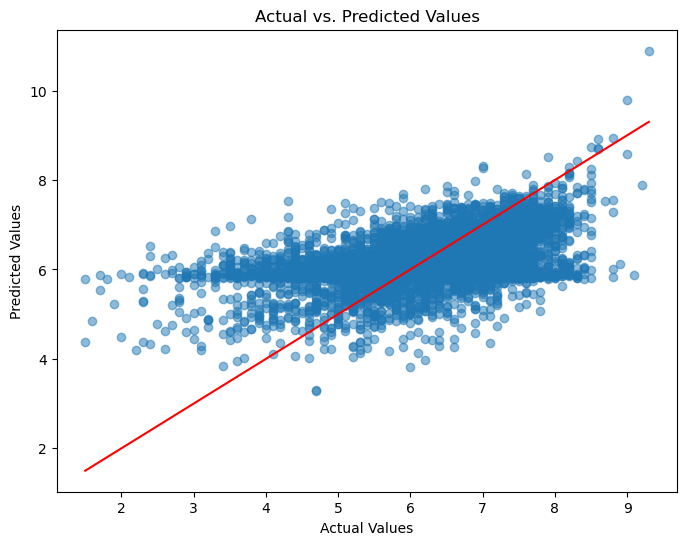

In [93]:
# plot the actual movie ratings vs the predicted movie ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line for perfect predictions
plt.show()

## Define the Model ("softplus")

In [94]:
# utilize "softplus" activation 
# It compiles the model with the Adam optimizer, mean squared error loss, and evaluates performance with MAE, MSE, and RMSE metrics, preparing it for training on continuous value prediction.
model_softplus = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='softplus', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='softplus'),
    tf.keras.layers.Dense(32, activation='softplus'),
    tf.keras.layers.Dense(1) 
])

model_softplus.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae', 'mse', rmse])  # Adjust metrics based on your task

In [95]:
model_softplus.fit(X_train_dense, y_train_dense, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
667/667 [==============================] - 46s 67ms/step - loss: 1.1936 - mae: 0.8280 - mse: 1.1936 - rmse: 1.0545 - val_loss: 1.0104 - val_mae: 0.7757 - val_mse: 1.0104 - val_rmse: 0.9941
Epoch 2/20
667/667 [==============================] - 43s 64ms/step - loss: 0.6784 - mae: 0.6021 - mse: 0.6784 - rmse: 0.8077 - val_loss: 0.9119 - val_mae: 0.7185 - val_mse: 0.9119 - val_rmse: 0.9436
Epoch 3/20
667/667 [==============================] - 44s 65ms/step - loss: 0.2962 - mae: 0.3992 - mse: 0.2962 - rmse: 0.5322 - val_loss: 0.8916 - val_mae: 0.7305 - val_mse: 0.8916 - val_rmse: 0.9342
Epoch 4/20
667/667 [==============================] - 44s 65ms/step - loss: 0.1427 - mae: 0.2764 - mse: 0.1427 - rmse: 0.3680 - val_loss: 0.9134 - val_mae: 0.7449 - val_mse: 0.9134 - val_rmse: 0.9462
Epoch 5/20
667/667 [==============================] - 44s 66ms/step - loss: 0.0864 - mae: 0.2213 - mse: 0.0864 - rmse: 0.2866 - val_loss: 0.8852 - val_mae: 0.7136 - val_mse: 0.8852 - val_rmse: 0.9306


In [96]:
# model's architecture details like layer types, outputs, and the number of parameters, in the variable DNN_sum
model_softplus_sum = model_softplus.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               5823232   
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5833601 (22.25 MB)
Trainable params: 5833601 (22.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
# Convert test data from sparse to dense
X_test_dense = X_test.toarray() 

# Evaluate the model with dense test data
score = model_softplus.evaluate(X_test_dense, y_test)
print("Evaluation score:", score)

# Make predictions with dense test data
predictions = model_softplus.predict(X_test_dense)
print("Predictions:", predictions)

209/209 [==============================] - 1s 5ms/step - loss: 0.8887 - mae: 0.7222 - mse: 0.8887 - rmse: 0.9330
Evaluation score: [0.8887189030647278, 0.7221854329109192, 0.8887189030647278, 0.9330288171768188]
209/209 [==============================] - 1s 6ms/step
Predictions: [[6.859605 ]
 [6.8883023]
 [6.762478 ]
 ...
 [6.4462395]
 [7.128148 ]
 [6.9010715]]


### Model Evaluation ('softplus'):

#### Loss:
The model achieved a loss of 0.8887, indicating the average magnitude of error in the model's predictions. However, whether this is acceptable depends on the specific standards and requirements based on our application and industry standards. For our project this is considered a acceptable standard for loss.

#### Mean Absolute Error (MAE):
With a value of 0.7222, this metric tells us that, on average, the model's predictions are about 0.7222 points away from the actual movie ratings. Considering the full rating scale of 0 to 10, this level of MAE reflects a reasonably accurate prediction capability, although there is certainly room for improvement.

#### The Mean Squared Error (MSE):
The MSE, also 0.8887, reflects the average squared difference between the estimated values and the actual value. This squaring penalizes larger errors more than smaller ones.

#### Model Performance:
The model appears to be somewhat consistent in its predictions, focusing around a central range of values. This suggest that the dataset predominantly contains movies with mid-range ratings or that the model has limitations in capturing the full variability in movie ratings.


## Prediction "Softplus" model

In [100]:
# Step 1: Preprocess the new movie data
new_movie_preprocessed = preprocessor.transform(Test)

# If your model requires a dense input, convert the sparse matrix to a dense array
new_movie_preprocessed_dense = new_movie_preprocessed.toarray()

# Step 2: Predict the rating using the trained model
predicted_rating = model_softplus.predict(new_movie_preprocessed_dense)

print("Movie name: ", Test['title_name'][1:2], ", Actual Rating = :" , Test['averageRating'][1:2])
print("Predicted Average Rating:", predicted_rating[1:2])

209/209 [==============================] - 1s 5ms/step
Movie name:  29497    Spy
Name: title_name, dtype: object , Actual Rating = : 29497    7.0
Name: averageRating, dtype: float64
Predicted Average Rating: [[6.8883023]]


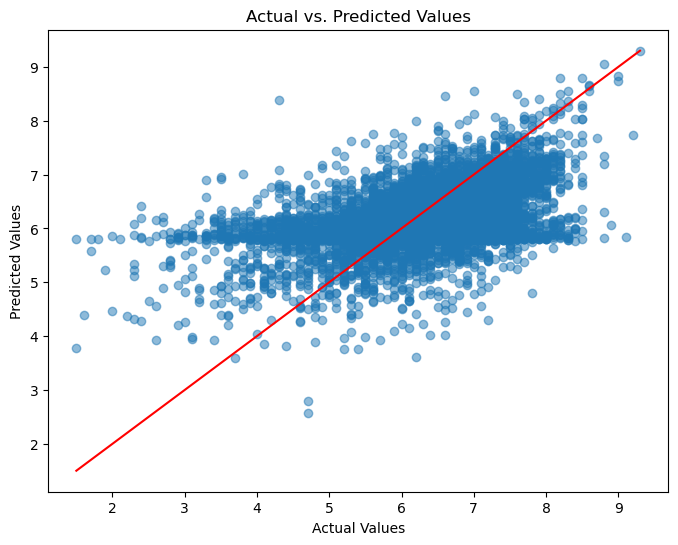

In [101]:
# plot the actual movie ratings vs the predicted movie ratings
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line for perfect predictions
plt.show()